## 타이타닉 생존자 예측

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from matplotlib import font_manager, rc # Only for mac
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import titanic

In [2]:
# MAC 한글 깨짐 처리
## Windows 환경에서는 반드시 제외!!
rc('font', family = 'AppleGothic')

In [3]:
df = pd.read_csv('train_titanic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df2 = df

## NULL 값 처리
df['Age'].fillna(df2['Age'].mean(), inplace=True)
df2['Cabin'].fillna('N', inplace = True)

## 잔여 NULL 유무 확인
df2.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64

In [5]:
## SEX 분포
df2['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [6]:
## Cabin 분포
print(df2['Cabin'].value_counts())

Cabin
N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64


In [7]:
## Embarked 분포
df2['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [8]:
# Cabin 분포 재가공
## N이 가장 많고, 속성값이 제대로 정리되지 않았기 때문

df2['Cabin'] = df['Cabin'].str[:1]
df2['Cabin'].value_counts()

Cabin
N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [9]:
g = df2.groupby(['Sex', 'Survived'])
g['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

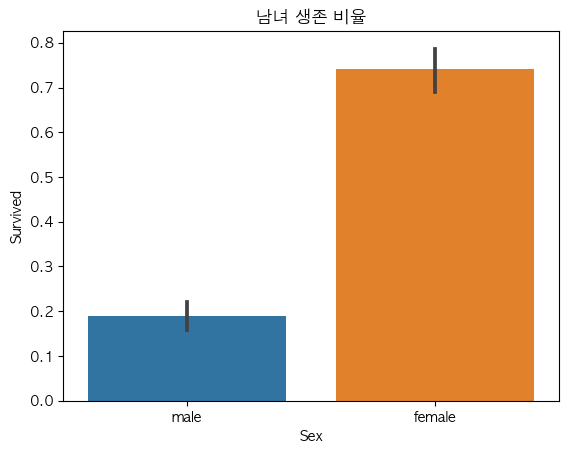

In [10]:
plt.figure()
plt.title("남녀 생존 비율")
ax = plt.gca()
sns.barplot(x='Sex', y='Survived', data=df, ax = ax)
plt.show()

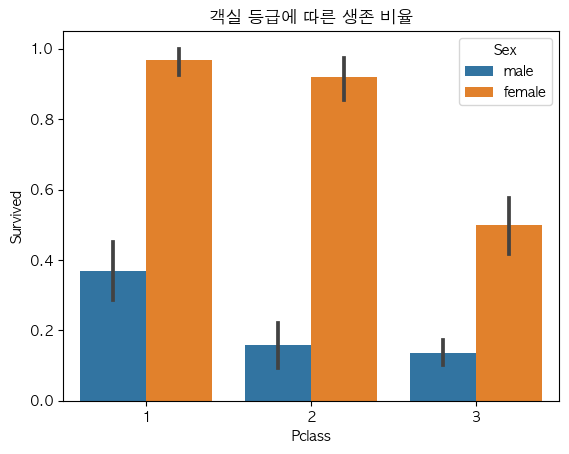

In [11]:
plt.figure()
plt.title("객실 등급에 따른 생존 비율")
ax = plt.gca()
sns.barplot(x='Pclass', y = 'Survived', hue = 'Sex', data = df, ax = ax)
plt.show()

In [12]:
df['Age_cate'] = df2['Age'].apply(lambda x:titanic.get_category(x))

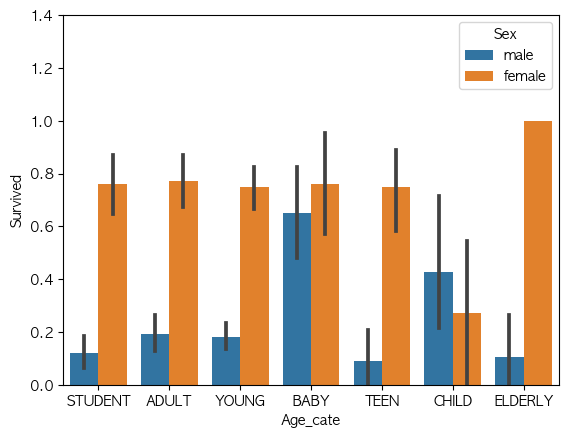

In [13]:
plt.figure()

ax = plt.gca()
sns.barplot(x="Age_cate", y="Survived", hue = "Sex", data = df, ax = ax)
plt.ylim(0,1.4)
plt.show()

In [14]:
df2 = titanic.encode_features(df2, ['Cabin', 'Sex', 'Embarked', 'Age_cate'])
df2[['Cabin', 'Sex', 'Embarked', 'Age_cate']].head(5)

,Cabin,Sex,Embarked,Age_cate
0,7,1,2,4
1,2,0,0,0
2,7,0,2,6
3,2,0,2,6
4,7,1,2,6


In [15]:
df2['CN'] = df2['Name'].apply(lambda x:titanic.get_name_index(x))
df2['CN'].value_counts()

CN
0    517
2    182
1    125
3     40
5     20
4      7
Name: count, dtype: int64

In [16]:
df3 = df2.drop(['PassengerId', 'Name', 'Ticket', 'Age'], axis=1)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     891 non-null    int64  
 7   Embarked  891 non-null    int64  
 8   Age_cate  891 non-null    int64  
 9   CN        891 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 69.7 KB


In [17]:
xdf = df3.drop('Survived', axis=1)
ydf = df3['Survived']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(xdf,ydf)

In [19]:
## 로지스틱 회귀 분류기
lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
accuracy_score(y_test, lr_pred)

0.7937219730941704

In [20]:
df3.corr()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Age_cate,CN
Survived,1.000000,-0.338481,-0.543351,-0.035322,0.081629,0.257307,-0.295113,-0.163517,-0.060861,0.387512
Pclass,-0.338481,1.000000,0.131900,0.083081,0.018443,-0.549500,0.742093,0.157112,0.244182,-0.144292
Sex,-0.543351,0.131900,1.000000,-0.114631,-0.245489,-0.182333,0.118635,0.104057,0.033941,-0.529582
SibSp,-0.035322,0.083081,-0.114631,1.000000,0.414838,0.159651,0.041058,0.066654,-0.070245,0.238506
Parch,0.081629,0.018443,-0.245489,0.414838,1.000000,0.216225,-0.031553,0.038322,-0.237680,0.235903
Fare,0.257307,-0.549500,-0.182333,0.159651,0.216225,1.000000,-0.525742,-0.221226,-0.127453,0.134482
Cabin,-0.295113,0.742093,0.118635,0.041058,-0.031553,-0.525742,1.000000,0.191973,0.213411,-0.129746
Embarked,-0.163517,0.157112,0.104057,0.066654,0.038322,-0.221226,0.191973,1.000000,-0.050778,-0.093261
Age_cate,-0.060861,0.244182,0.033941,-0.070245,-0.237680,-0.127453,0.213411,-0.050778,1.000000,-0.186745
CN,0.387512,-0.144292,-0.529582,0.238506,0.235903,0.134482,-0.129746,-0.093261,-0.186745,1.000000


In [21]:
lr = LogisticRegression(solver='liblinear')
cross_val_score(lr, xdf, ydf, cv = 5)

array([0.79888268, 0.80337079, 0.7752809 , 0.78651685, 0.79775281])

In [22]:
lr = LogisticRegression(solver='liblinear')
titanic.exec_kfold(lr, xdf, ydf)

0.7932960893854749
0.8089887640449438
0.7808988764044944
0.7640449438202247
0.8146067415730337


In [23]:
parameters = {'max_depth':[2,3,5,10],
              'min_samples_split':[2,3,5],
              'min_samples_leaf':[1,5,8]}

dtc = DecisionTreeClassifier()
grid_model = GridSearchCV(dtc, param_grid=parameters, scoring='accuracy', cv=5)
grid_model.fit(x_train, y_train)

print("최고 파라미터: ", grid_model.best_params_)
print("최고 정확도: ", grid_model.best_score_)

best_model = grid_model.best_estimator_
pred_val = best_model.predict(x_test)
print("acc: ", accuracy_score(y_test, pred_val))

최고 파라미터:  {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 3}
최고 정확도:  0.8218606217035125
acc:  0.8161434977578476
